In [3]:
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import pandas as pd

Classes: ['ai-midjourney', 'real']
           class  num_samples    resolution file_formats
0  ai-midjourney         1356  {(240, 240)}       {JPEG}
1           real          825  {(240, 240)}       {JPEG}


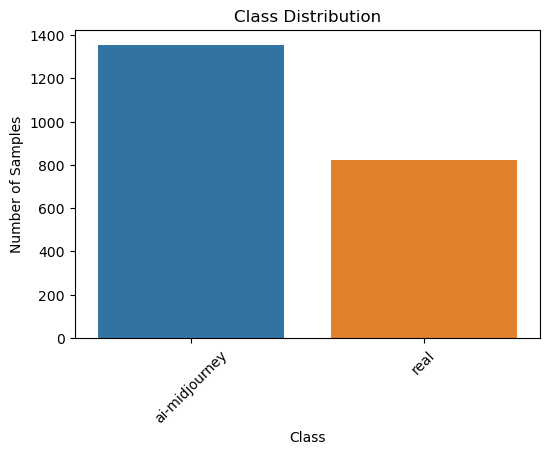

Class Imbalance: 64.36%


In [4]:
# Set the path to your dataset
data_dir = r"C:\Users\Dell Pc\Downloads\archive"

# Get the list of classes (subfolders)
classes = os.listdir(data_dir)
print("Classes:", classes)

# Dictionary to store information about each class
class_info = {
    "class": [],
    "num_samples": [],
    "resolution": [],
    "file_formats": []
}

# Iterate through each class folder
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    num_samples = len(os.listdir(class_dir))
    class_info["class"].append(class_name)
    class_info["num_samples"].append(num_samples)

    # Get resolution and file format information for each sample in the class
    resolutions = set()
    file_formats = set()
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        img = Image.open(file_path)
        resolutions.add(img.size)
        file_formats.add(img.format)
    class_info["resolution"].append(resolutions)
    class_info["file_formats"].append(file_formats)

# Create a DataFrame from the class information dictionary
class_df = pd.DataFrame(class_info)

# Display the DataFrame
print(class_df)

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x="class", y="num_samples", data=class_df)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

# Check for class imbalances
min_samples = class_df["num_samples"].min()
max_samples = class_df["num_samples"].max()
class_imbalance = (max_samples - min_samples) / min_samples * 100
print("Class Imbalance: {:.2f}%".format(class_imbalance))


Clean the data: check for corrupt images, duplicates, or missing values.

In [5]:
from tqdm import tqdm

# Function to check for corrupt images
def is_corrupt_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify() # Verifies if the image file is broken
        return False
    except (IOError, SyntaxError):
        return True

# Function to check for duplicate images
def find_duplicates(files):
    seen = set()
    duplicates = []
    for file in files:
        if file not in seen:
            seen.add(file)
        else:
            duplicates.append(file)
    return duplicates

# Dictionary to store information about corrupted images and duplicates
data_quality_info = {
    "class": [],
    "num_corrupt_images": [],
    "num_duplicates": []
}

# Iterate through each class folder
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    corrupt_images = 0
    duplicates = []
    files = []
    
    # Check for corrupt images and duplicates
    for file_name in tqdm(os.listdir(class_dir), desc=f"Checking {class_name}"):
        file_path = os.path.join(class_dir, file_name)
        if is_corrupt_image(file_path):
            corrupt_images += 1
        files.append(file_name)
    
    # Find duplicates
    duplicates = find_duplicates(files)
    
    # Update data_quality_info dictionary
    data_quality_info["class"].append(class_name)
    data_quality_info["num_corrupt_images"].append(corrupt_images)
    data_quality_info["num_duplicates"].append(len(duplicates))

# Create a DataFrame from the data quality information dictionary
data_quality_df = pd.DataFrame(data_quality_info)

# Display the DataFrame
print(data_quality_df)


Checking real: 100%|██████████| 825/825 [00:00<00:00, 4127.82it/s]

           class  num_corrupt_images  num_duplicates
0  ai-midjourney                   0               0
1           real                   0               0


visualizing sample images from both the classes

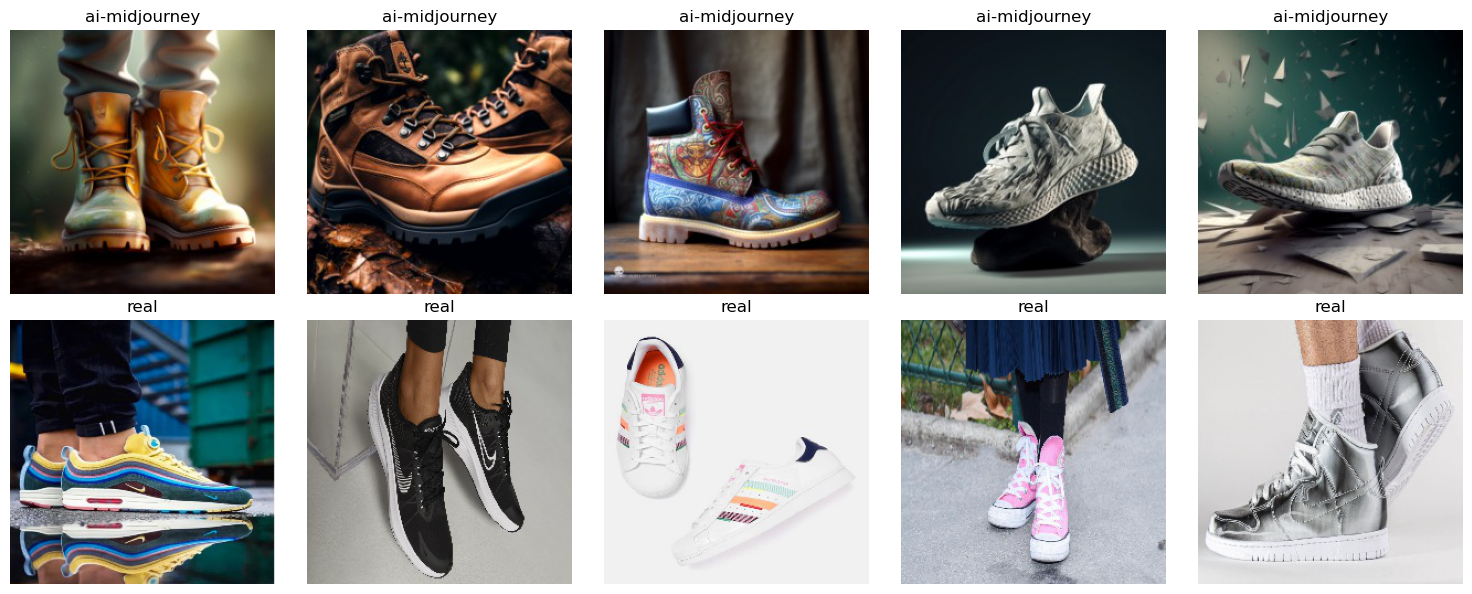

In [6]:
import random

data_dir = r"C:\Users\Dell Pc\Downloads\archive"
# Number of sample images to visualize from each class
num_samples_to_visualize = 5

# Plot sample images
plt.figure(figsize=(15, 6))

# Iterate through each class folder
for i, class_name in enumerate(classes, start=1):
    class_dir = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_dir)
    # Randomly select sample images from the class
    sample_images = random.sample(image_files, num_samples_to_visualize)
    
    # Plot sample images
    for j, image_file in enumerate(sample_images, start=1):
        image_path = os.path.join(class_dir, image_file)
        img = Image.open(image_path)
        plt.subplot(len(classes), num_samples_to_visualize, (i-1)*num_samples_to_visualize + j)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()


Visualize pixel intensity distributions to understand variations in images

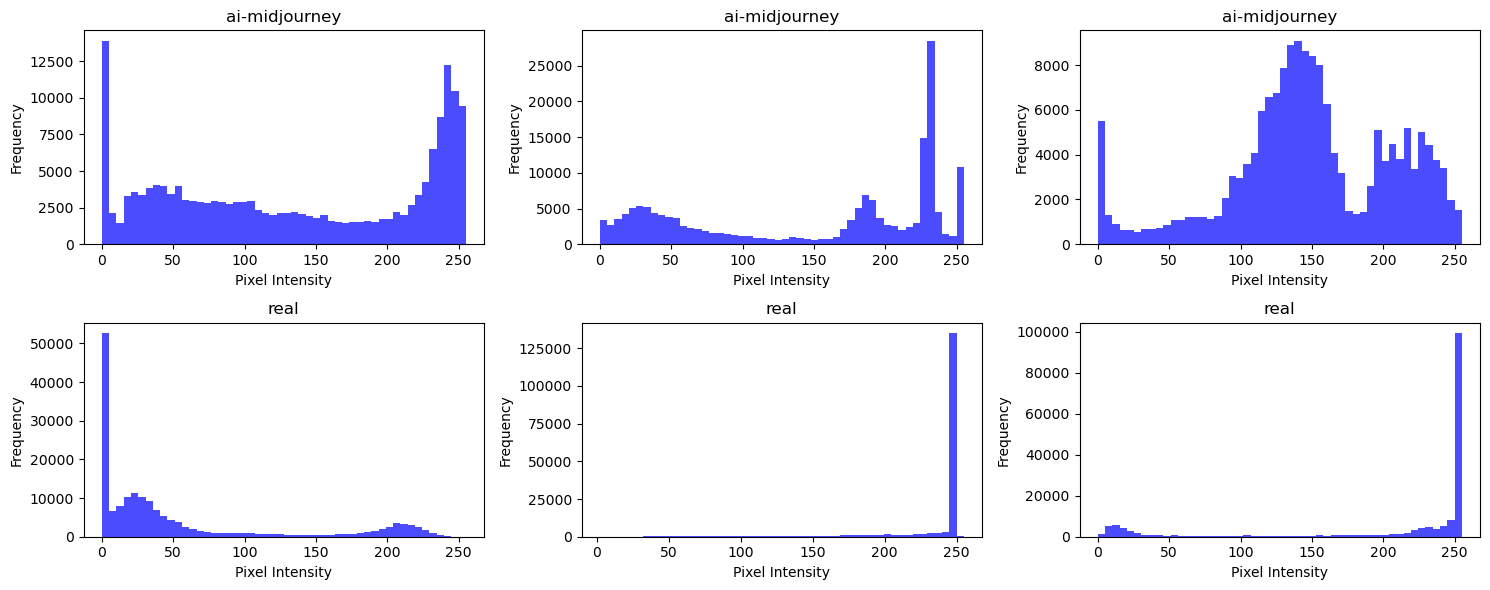

In [7]:
# Number of images to visualize for pixel intensity distributions
num_images_to_visualize = 3

# Plot pixel intensity distributions
plt.figure(figsize=(15, 6))

# Iterate through each class folder
for i, class_name in enumerate(classes, start=1):
    class_dir = os.path.join(data_dir, class_name)
    try:
        image_files = os.listdir(class_dir)
        # Randomly select sample images from the class
        sample_images = random.sample(image_files, min(num_images_to_visualize, len(image_files)))
        
        # Plot pixel intensity distributions
        for j, image_file in enumerate(sample_images, start=1):
            image_path = os.path.join(class_dir, image_file)
            img = Image.open(image_path)
            img_array = np.array(img)
            # Flatten the image array
            img_flat = img_array.flatten()
            plt.subplot(len(classes), num_images_to_visualize, (i-1)*num_images_to_visualize + j)
            plt.hist(img_flat, bins=50, color='blue', alpha=0.7)
            plt.title(class_name)
            plt.xlabel('Pixel Intensity')
            plt.ylabel('Frequency')
    except FileNotFoundError:
        print(f"Class directory not found: {class_dir}")

plt.tight_layout()
plt.show()


statistical analysis:

<Figure size 1800x1200 with 0 Axes>

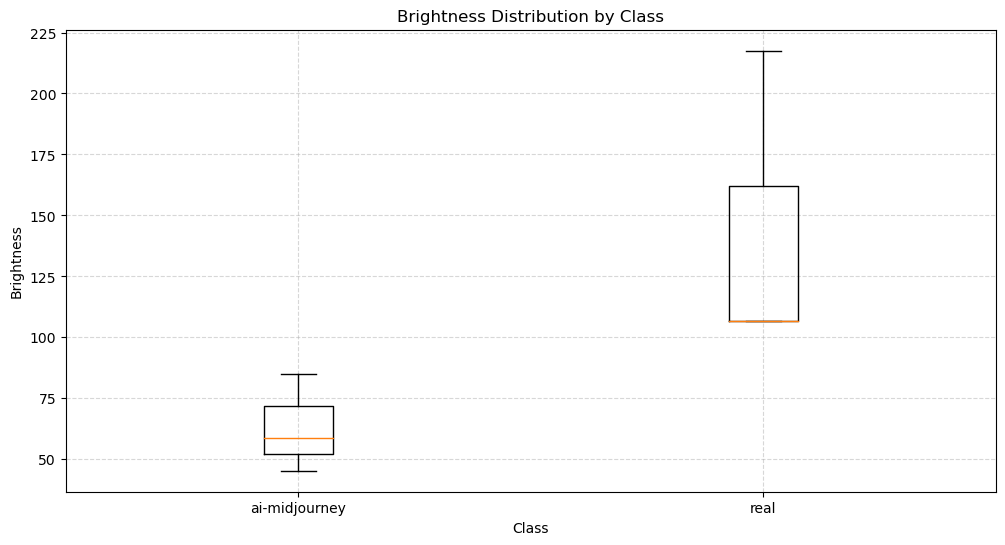

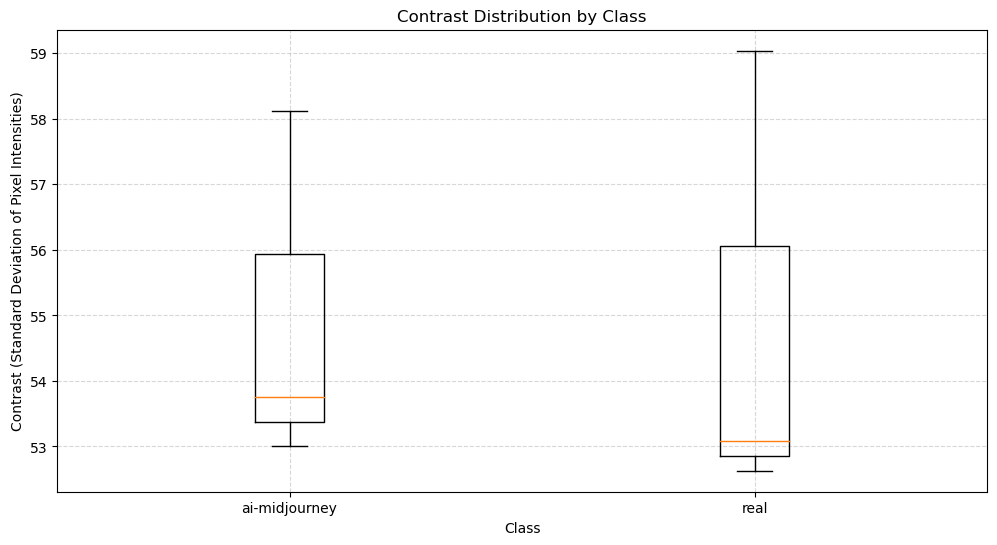

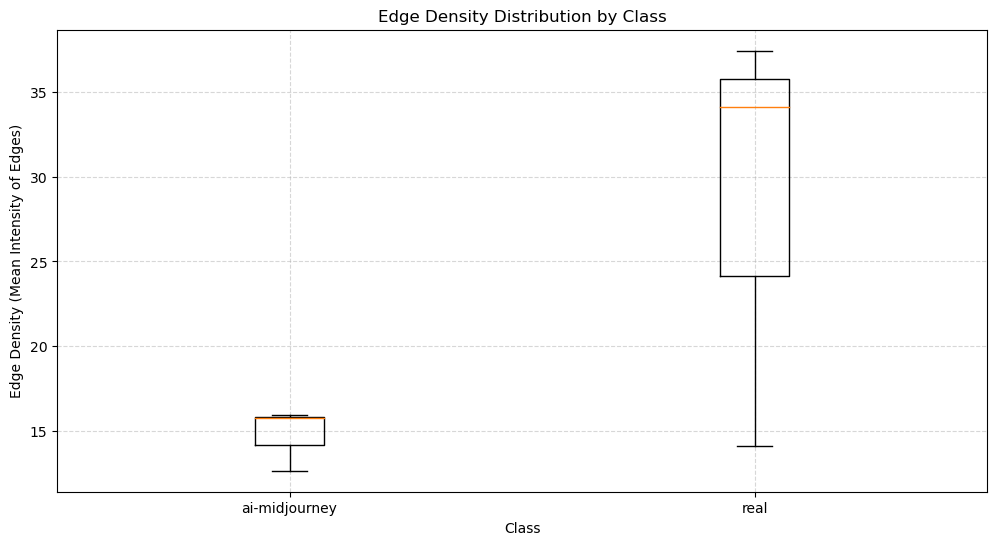

In [9]:
from PIL import Image, ImageEnhance, ImageFilter
# Initialize lists to store statistics
dimensions = []
aspect_ratios = []
color_channel_means = {'Red': [], 'Green': [], 'Blue': []}
brightness_values = []
contrast_values = []
edge_densities = []

# Set the figure size for the plot
plt.figure(figsize=(18, 12))

# Iterate through each class folder
for i, class_name in enumerate(classes, start=1):
    class_dir = os.path.join(data_dir, class_name)
    try:
        image_files = os.listdir(class_dir)
        # Randomly select sample images from the class
        sample_images = random.sample(image_files, min(num_images_to_visualize, len(image_files)))
        
        for j, image_file in enumerate(sample_images, start=1):
            image_path = os.path.join(class_dir, image_file)
            img = Image.open(image_path)
            img_array = np.array(img)

            # Compute image dimensions and aspect ratios
            width, height = img.size
            dimensions.append((class_name, width, height))
            aspect_ratios.append((class_name, width / height))
            
            # Compute mean color values for each channel
            if img_array.ndim == 3:  # If image has color channels
                color_channel_means['Red'].append((class_name, np.mean(img_array[:, :, 0])))
                color_channel_means['Green'].append((class_name, np.mean(img_array[:, :, 1])))
                color_channel_means['Blue'].append((class_name, np.mean(img_array[:, :, 2])))

            # Compute brightness
            enhancer = ImageEnhance.Brightness(img)
            brightness = np.mean(img_array)
            brightness_values.append((class_name, brightness))

            # Compute contrast
            contrast = np.std(img_array)
            contrast_values.append((class_name, contrast))

            # Compute edge density
            edges = img.filter(ImageFilter.FIND_EDGES)
            edge_density = np.mean(np.array(edges))
            edge_densities.append((class_name, edge_density))

           
    except FileNotFoundError:
        print(f"Class directory not found: {class_dir}")

plt.tight_layout()
plt.suptitle('Pixel Value Statistics for Sample Images', fontsize=16, y=1.02)
plt.show()




# Plot brightness distribution
plt.figure(figsize=(12, 6))
class_brightness = {class_name: [] for class_name in classes}
for class_name, brightness in brightness_values:
    class_brightness[class_name].append(brightness)

plt.boxplot([class_brightness[class_name] for class_name in classes], labels=classes)
plt.title('Brightness Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Brightness')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Plot contrast distribution
plt.figure(figsize=(12, 6))
class_contrast = {class_name: [] for class_name in classes}
for class_name, contrast in contrast_values:
    class_contrast[class_name].append(contrast)

plt.boxplot([class_contrast[class_name] for class_name in classes], labels=classes)
plt.title('Contrast Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Contrast (Standard Deviation of Pixel Intensities)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Plot edge density distribution
plt.figure(figsize=(12, 6))
class_edge_density = {class_name: [] for class_name in classes}
for class_name, edge_density in edge_densities:
    class_edge_density[class_name].append(edge_density)

plt.boxplot([class_edge_density[class_name] for class_name in classes], labels=classes)
plt.title('Edge Density Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Edge Density (Mean Intensity of Edges)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<Figure size 1800x1200 with 0 Axes>

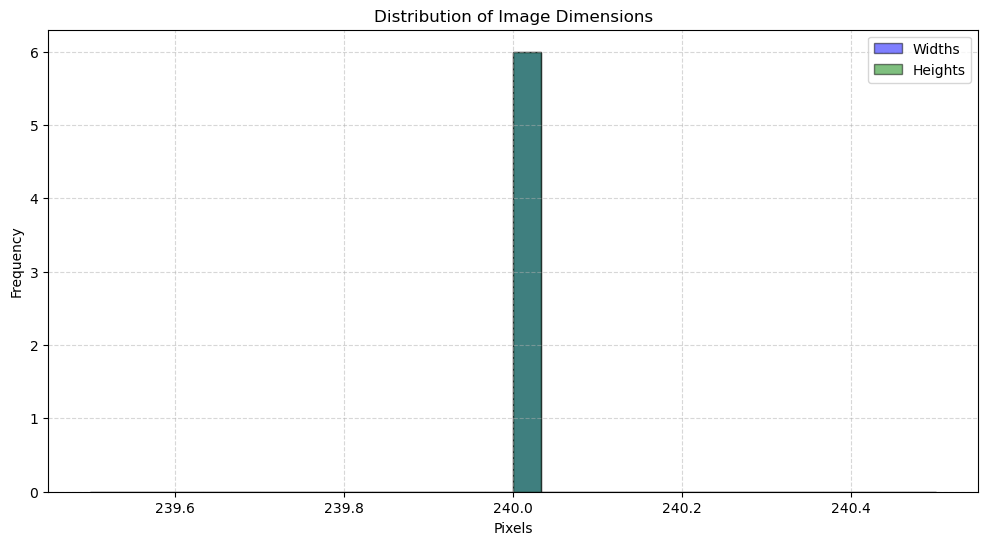

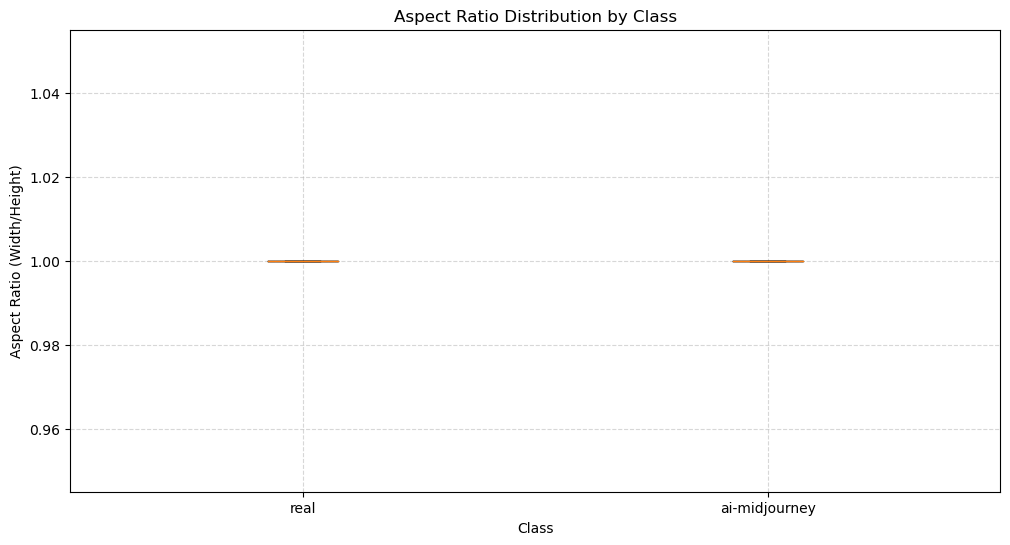

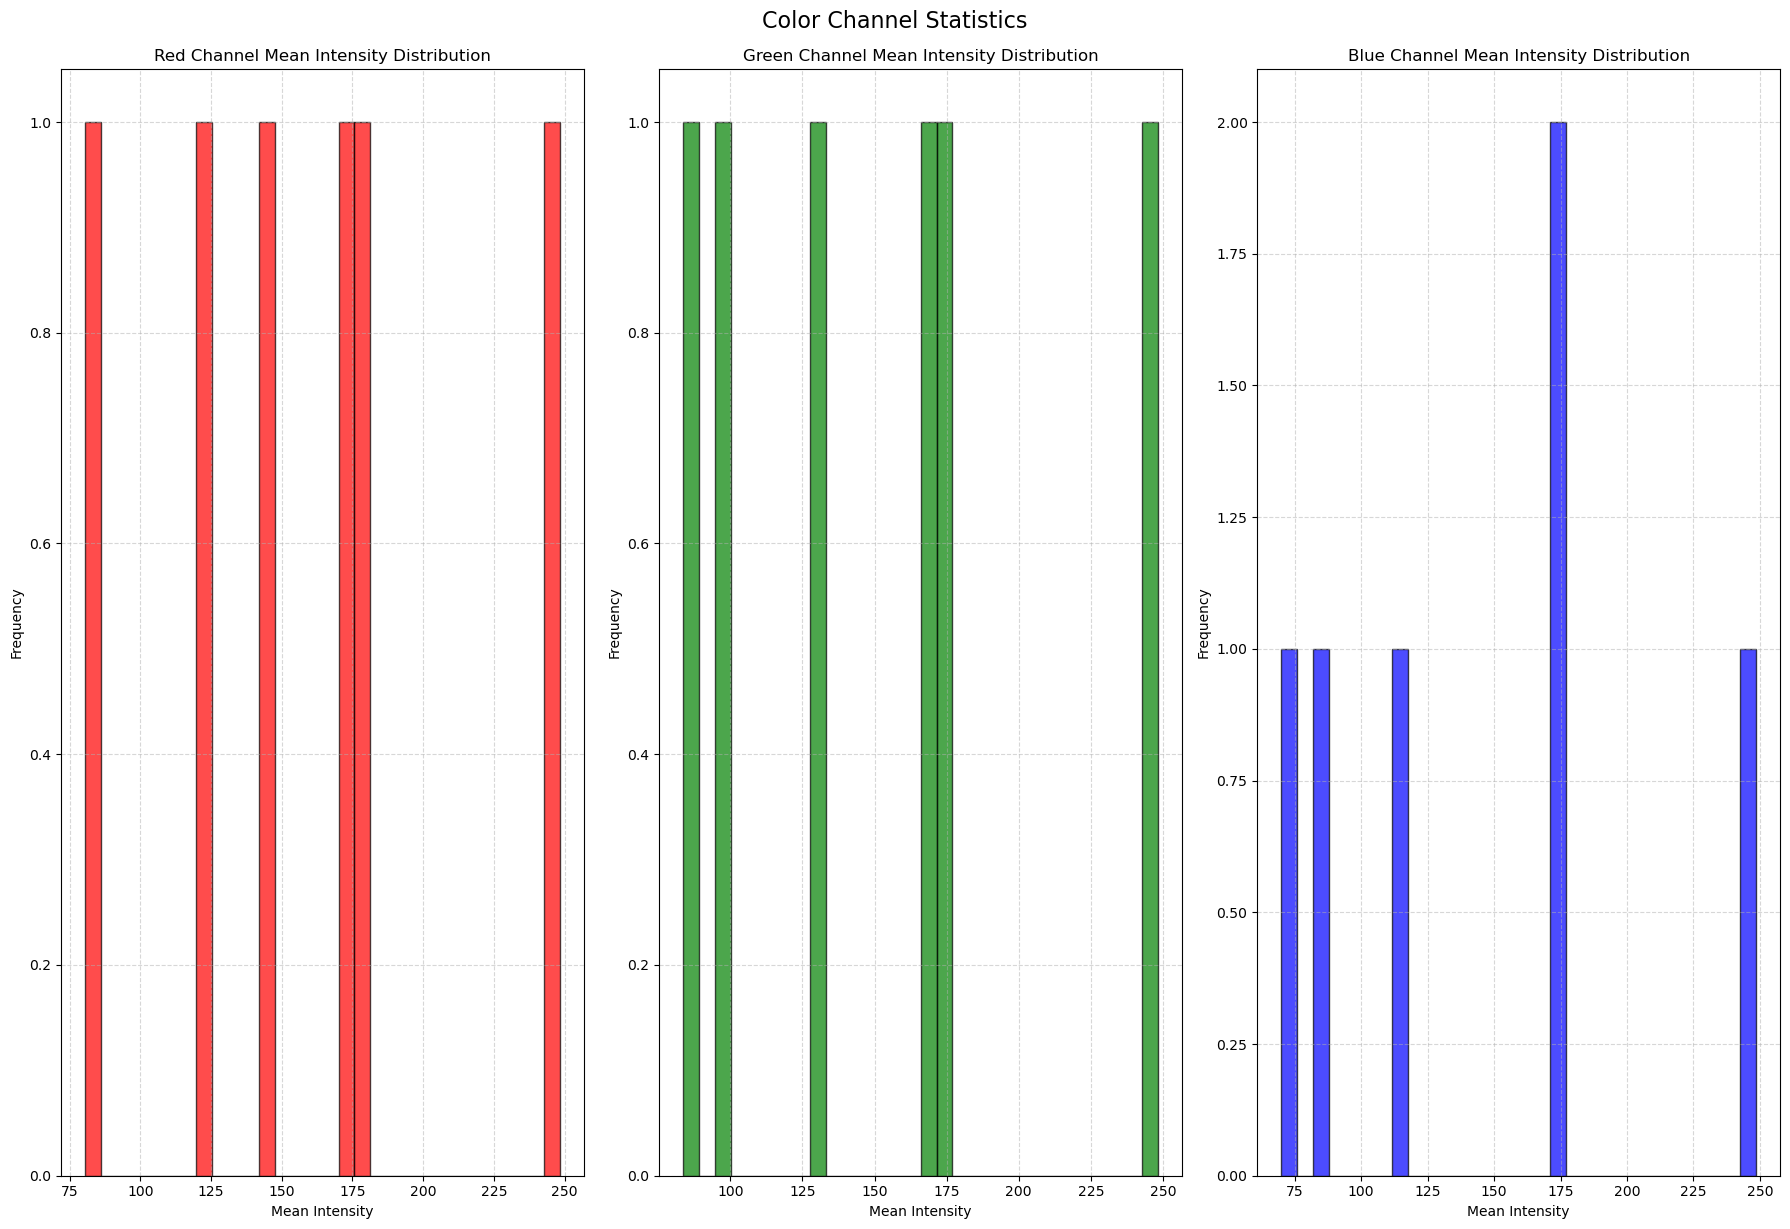

In [24]:
# Initialize lists to store statistics
dimensions = []
aspect_ratios = []
color_channel_means = {'Red': [], 'Green': [], 'Blue': []}

# Set the figure size for the plot
plt.figure(figsize=(18, 12))

# Iterate through each class folder
for i, class_name in enumerate(classes, start=1):
    class_dir = os.path.join(data_dir, class_name)
    try:
        image_files = os.listdir(class_dir)
        # Randomly select sample images from the class
        sample_images = random.sample(image_files, min(num_images_to_compute_stats, len(image_files)))
        
        for j, image_file in enumerate(sample_images, start=1):
            image_path = os.path.join(class_dir, image_file)
            img = Image.open(image_path)
            img_array = np.array(img)

            # Compute image dimensions and aspect ratios
            width, height = img.size
            dimensions.append((class_name, width, height))
            aspect_ratios.append((class_name, width / height))
            
            # Compute mean color values for each channel
            if img_array.ndim == 3:  # If image has color channels
                color_channel_means['Red'].append((class_name, np.mean(img_array[:, :, 0])))
                color_channel_means['Green'].append((class_name, np.mean(img_array[:, :, 1])))
                color_channel_means['Blue'].append((class_name, np.mean(img_array[:, :, 2])))

           
    except FileNotFoundError:
        print(f"Class directory not found: {class_dir}")

plt.tight_layout()
plt.suptitle('Pixel Value Statistics for Sample Images', fontsize=16, y=1.02)
plt.show()

# Plot image dimensions distribution
plt.figure(figsize=(12, 6))
widths = [dim[1] for dim in dimensions]
heights = [dim[2] for dim in dimensions]
plt.hist(widths, bins=30, alpha=0.5, label='Widths', color='blue', edgecolor='black')
plt.hist(heights, bins=30, alpha=0.5, label='Heights', color='green', edgecolor='black')
plt.title('Distribution of Image Dimensions')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Plot aspect ratio distribution
plt.figure(figsize=(12, 6))
class_aspect_ratios = {class_name: [] for class_name in classes}
for class_name, ratio in aspect_ratios:
    class_aspect_ratios[class_name].append(ratio)

plt.boxplot([class_aspect_ratios[class_name] for class_name in classes], labels=classes)
plt.title('Aspect Ratio Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Aspect Ratio (Width/Height)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Plot color channel statistics
plt.figure(figsize=(18, 12))
colors = ['Red', 'Green', 'Blue']
for i, color in enumerate(colors, start=1):
    plt.subplot(1, 3, i)
    color_means = [val[1] for val in color_channel_means[color]]
    plt.hist(color_means, bins=30, color=color.lower(), edgecolor='black', alpha=0.7)
    plt.title(f'{color} Channel Mean Intensity Distribution')
    plt.xlabel('Mean Intensity')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.suptitle('Color Channel Statistics', fontsize=16, y=1.02)
plt.show()

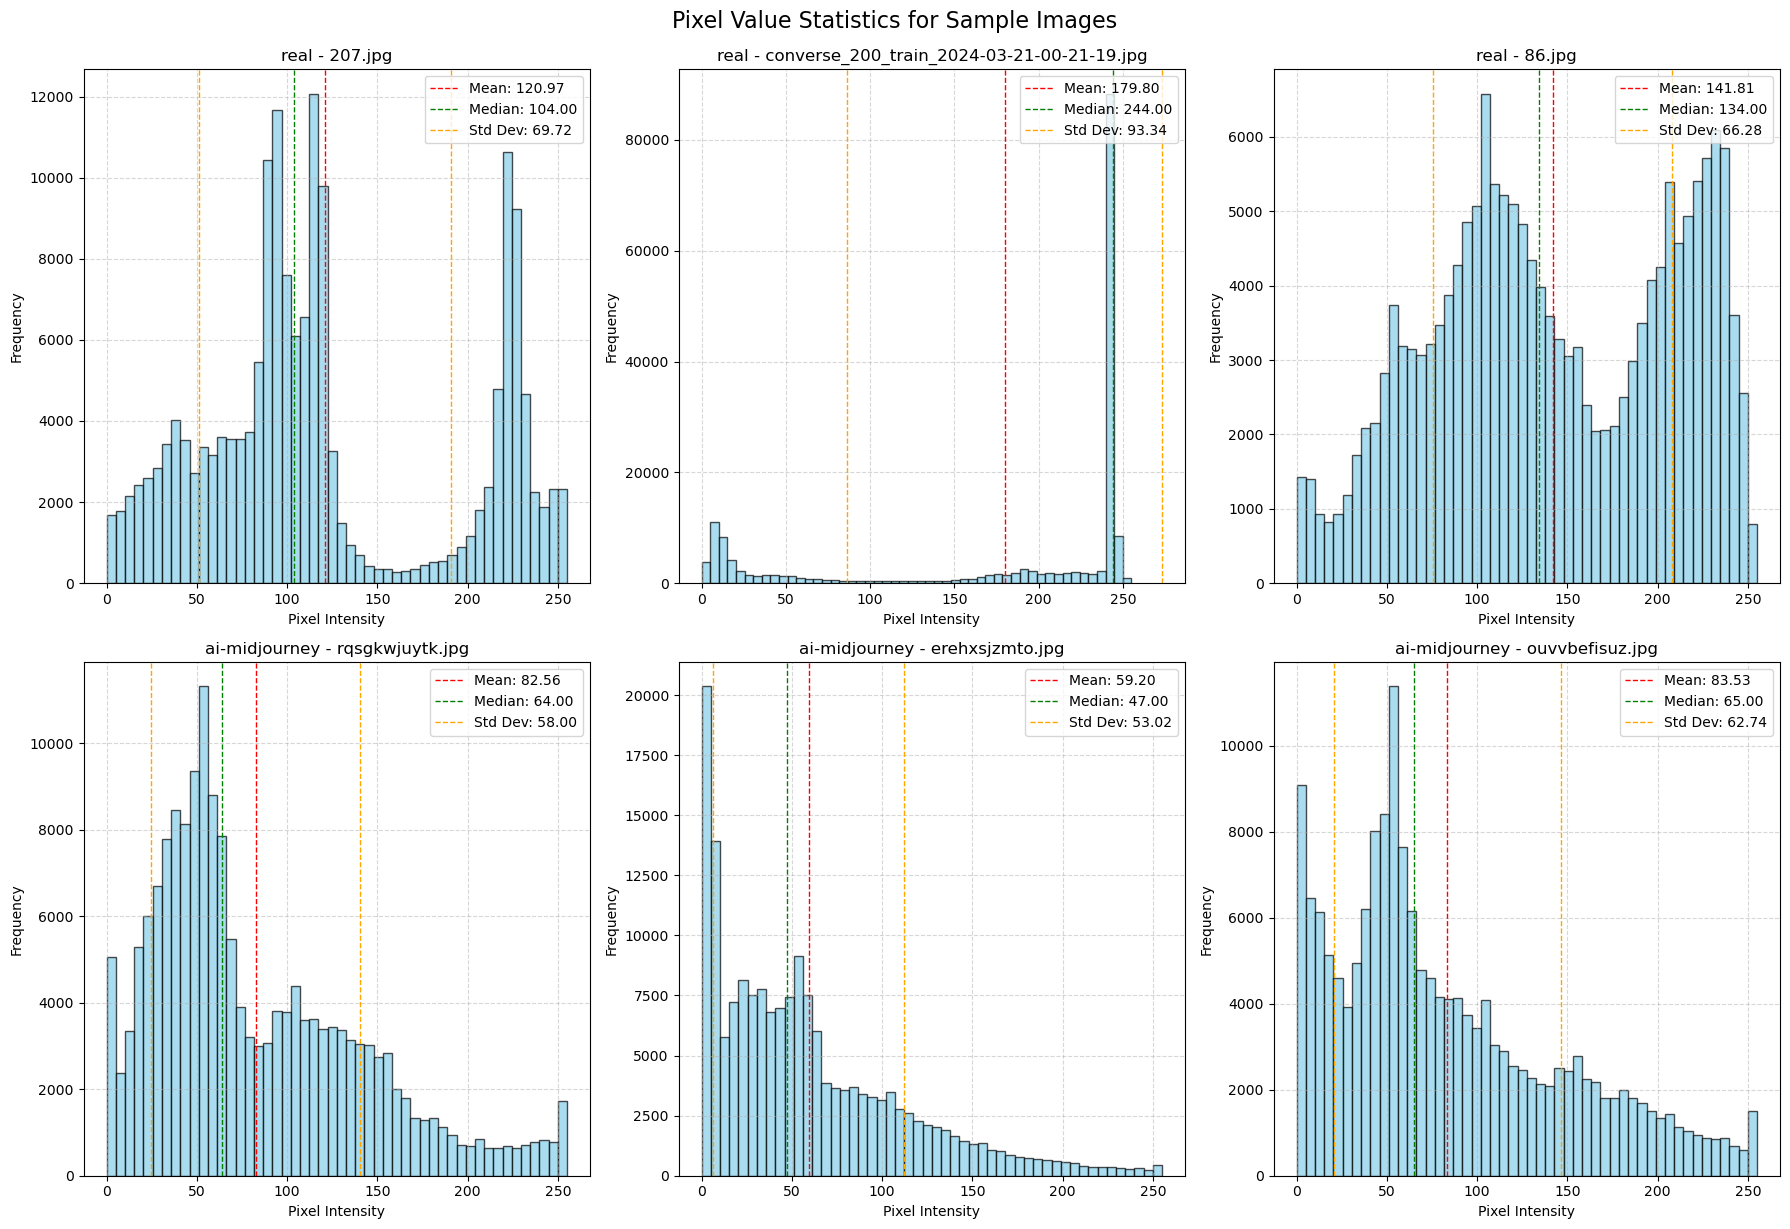

In [10]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Number of images to compute statistics for
num_images_to_compute_stats = 3

# Define the directory containing image classes and the list of class names
data_dir = r"C:\Users\Dell Pc\Downloads\archive"
classes = ['real', 'ai-midjourney']  # replace with your actual class names

# Set the figure size for the plot
plt.figure(figsize=(18, 12))

# Iterate through each class folder
for i, class_name in enumerate(classes, start=1):
    class_dir = os.path.join(data_dir, class_name)
    try:
        image_files = os.listdir(class_dir)
        # Randomly select sample images from the class
        sample_images = random.sample(image_files, min(num_images_to_compute_stats, len(image_files)))
        
        # Compute pixel value statistics and plot histograms
        for j, image_file in enumerate(sample_images, start=1):
            image_path = os.path.join(class_dir, image_file)
            img = Image.open(image_path)
            img_array = np.array(img)
            # Compute statistics
            img_mean = np.mean(img_array)
            img_median = np.median(img_array)
            img_std = np.std(img_array)
            # Plot histogram for pixel value statistics
            ax = plt.subplot(len(classes), num_images_to_compute_stats, (i-1)*num_images_to_compute_stats + j)
            ax.hist(img_array.flatten(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
            ax.axvline(img_mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {img_mean:.2f}')
            ax.axvline(img_median, color='green', linestyle='dashed', linewidth=1, label=f'Median: {img_median:.2f}')
            ax.axvline(img_mean + img_std, color='orange', linestyle='dashed', linewidth=1, label=f'Std Dev: {img_std:.2f}')
            ax.axvline(img_mean - img_std, color='orange', linestyle='dashed', linewidth=1)
            ax.set_title(f'{class_name} - {image_file}')
            ax.set_xlabel('Pixel Intensity')
            ax.set_ylabel('Frequency')
            ax.legend(loc='upper right')
            ax.grid(True, linestyle='--', alpha=0.5)
    except FileNotFoundError:
        print(f"Class directory not found: {class_dir}")

plt.tight_layout()
plt.suptitle('Pixel Value Statistics for Sample Images', fontsize=16, y=1.02)
plt.show()


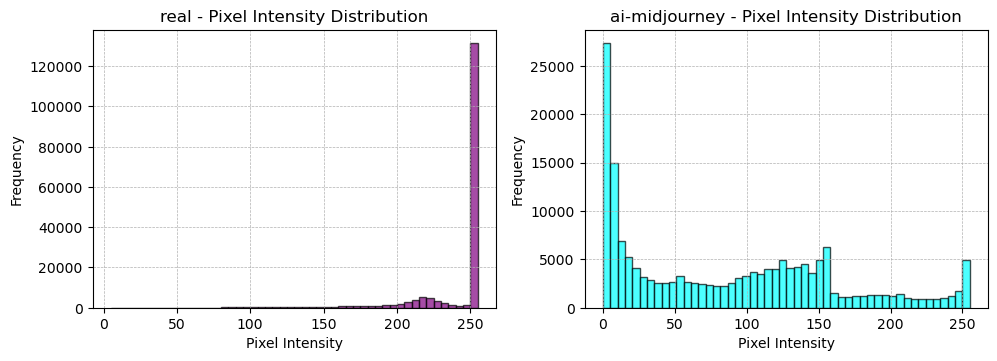

In [11]:
# Define colors for each class
colors = ['purple', 'cyan']

plt.figure(figsize=(15, 10))

# Histogram of pixel intensity distributions for each class
for i, class_name in enumerate(classes, start=1):
    class_dir = os.path.join(data_dir, class_name)
    try:
        image_files = os.listdir(class_dir)
        sample_image_path = os.path.join(class_dir, random.choice(image_files))
        img = Image.open(sample_image_path)
        img_array = np.array(img)
        plt.subplot(3, 3, i)
        plt.hist(img_array.flatten(), bins=50, color=colors[i-1], alpha=0.7, edgecolor='black')
        plt.title(f'{class_name} - Pixel Intensity Distribution')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.grid(True, linestyle='--', linewidth=0.5)
    except FileNotFoundError:
        print(f"Class directory not found: {class_dir}")

plt.tight_layout()
plt.show()

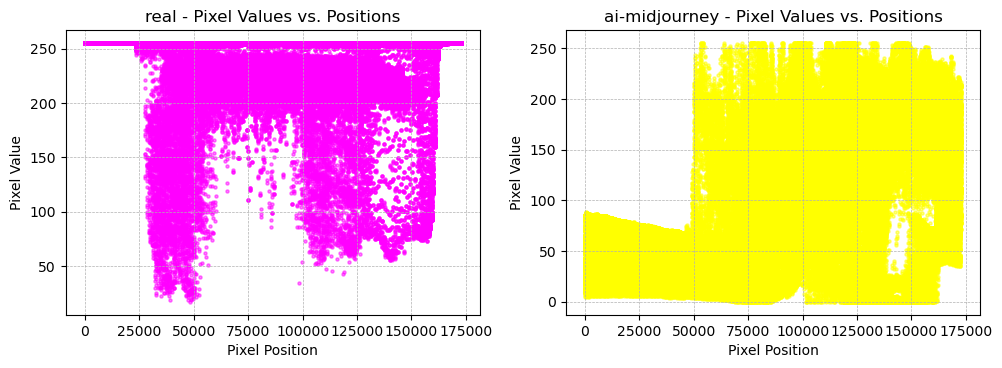

In [12]:
# Define colors for each class
colors = ['magenta', 'yellow']

plt.figure(figsize=(15, 10))

# Scatter plot of pixel values vs. pixel positions for a sample image
for i, class_name in enumerate(classes, start=1):
    class_dir = os.path.join(data_dir, class_name)
    try:
        image_files = os.listdir(class_dir)
        sample_image_path = os.path.join(class_dir, random.choice(image_files))
        img = Image.open(sample_image_path)
        img_array = np.array(img)
        plt.subplot(3, 3, i+3)
        plt.scatter(np.arange(len(img_array.flatten())), img_array.flatten(), s=5, color=colors[i-1], alpha=0.5)
        plt.title(f'{class_name} - Pixel Values vs. Positions')
        plt.xlabel('Pixel Position')
        plt.ylabel('Pixel Value')
        plt.grid(True, linestyle='--', linewidth=0.5)
    except FileNotFoundError:
        print(f"Class directory not found: {class_dir}")

plt.tight_layout()
plt.show()

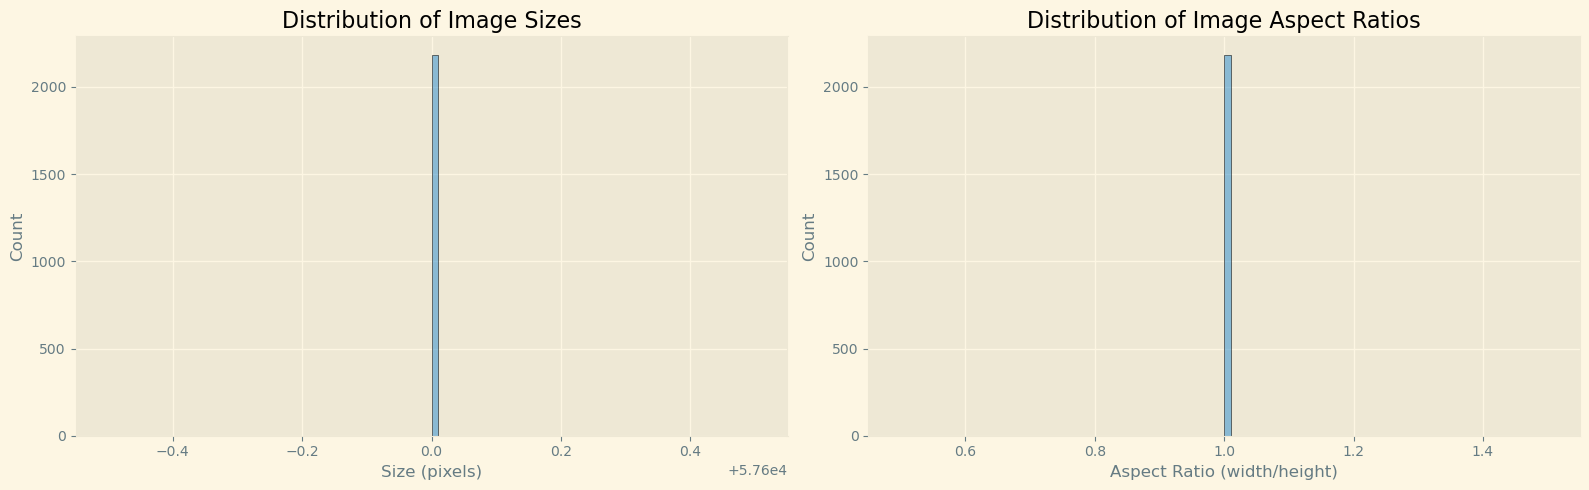

In [13]:
# Initialize a list to store image data
image_data = []

# Iterate through each class folder
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        try:
            img = Image.open(file_path)
            width, height = img.size
            size = width * height
            aspect_ratio = width / height
            image_data.append({
                "class": class_name,
                "size": size,
                "aspect_ratio": aspect_ratio
            })
        except (IOError, SyntaxError) as e:
            print(f"Cannot process image {file_path}: {e}")

# Convert the image data to a DataFrame
image_df = pd.DataFrame(image_data)

# Use the specified style
plt.style.use('Solarize_Light2')

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Plot the distribution of image sizes
sns.histplot(x='size', data=image_df, bins=100, ax=ax[0], kde=True)
ax[0].set_title("Distribution of Image Sizes")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Size (pixels)")

# Plot the distribution of image aspect ratios
sns.histplot(x='aspect_ratio', data=image_df, bins=100, ax=ax[1], kde=True)
ax[1].set_title("Distribution of Image Aspect Ratios")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Aspect Ratio (width/height)")

# Show the plots
plt.tight_layout()
plt.show()

histogram of color distribution: Shows the distribution of pixel intensity values for each color channel (Red, Green, Blue).

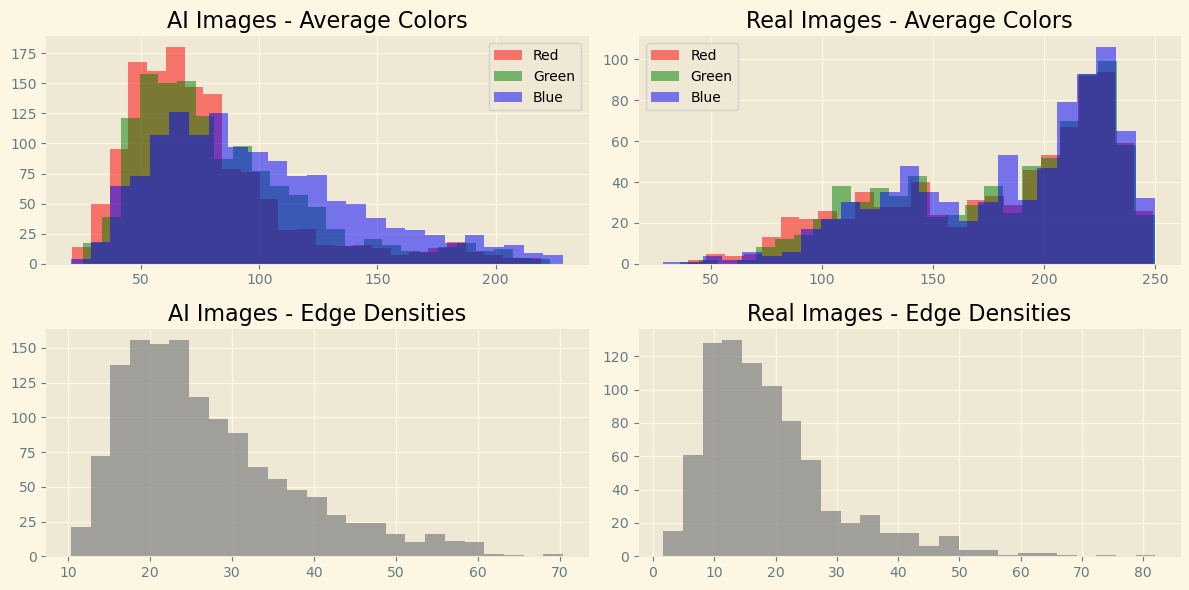

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import shannon_entropy
from sklearn.cluster import KMeans

# Define paths
ai_images_path = r"C:\Users\Dell Pc\Downloads\archive\ai-midjourney"
real_images_path = r"C:\Users\Dell Pc\Downloads\archive\real"

# Function to load images from a directory
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

# Load AI and real images
ai_images = load_images_from_folder(ai_images_path)
real_images = load_images_from_folder(real_images_path)

# Function to calculate average color
def average_color(image):
    return cv2.mean(image)[:3]

# Function to calculate edges using Canny edge detection
def edge_detection(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return np.sum(edges) / edges.size

# Calculate average colors and edge densities
ai_avg_colors = [average_color(img) for img in ai_images]
real_avg_colors = [average_color(img) for img in real_images]

ai_edge_densities = [edge_detection(img) for img in ai_images]
real_edge_densities = [edge_detection(img) for img in real_images]

# Convert to NumPy arrays for easier manipulation
ai_avg_colors = np.array(ai_avg_colors)
real_avg_colors = np.array(real_avg_colors)

ai_edge_densities = np.array(ai_edge_densities)
real_edge_densities = np.array(real_edge_densities)

# Plotting the average color distributions
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.title('AI Images - Average Colors')
plt.hist(ai_avg_colors[:, 0], bins=25, color='r', alpha=0.5, label='Red')
plt.hist(ai_avg_colors[:, 1], bins=25, color='g', alpha=0.5, label='Green')
plt.hist(ai_avg_colors[:, 2], bins=25, color='b', alpha=0.5, label='Blue')
plt.legend()

plt.subplot(2, 2, 2)
plt.title('Real Images - Average Colors')
plt.hist(real_avg_colors[:, 0], bins=25, color='r', alpha=0.5, label='Red')
plt.hist(real_avg_colors[:, 1], bins=25, color='g', alpha=0.5, label='Green')
plt.hist(real_avg_colors[:, 2], bins=25, color='b', alpha=0.5, label='Blue')
plt.legend()

# Plotting the edge density distributions
plt.subplot(2, 2, 3)
plt.title('AI Images - Edge Densities')
plt.hist(ai_edge_densities, bins=25, color='gray', alpha=0.7)

plt.subplot(2, 2, 4)
plt.title('Real Images - Edge Densities')
plt.hist(real_edge_densities, bins=25, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()


General Visulizations on data:

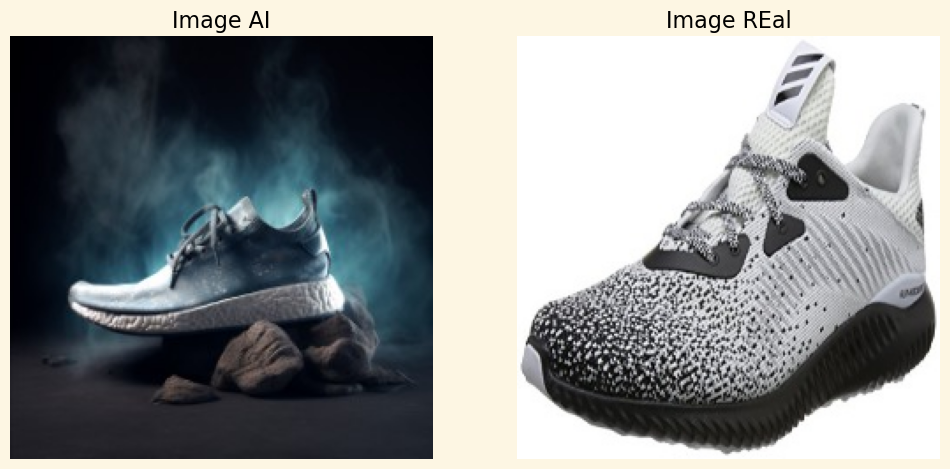

In [16]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# Define the folder paths
folder_path_a = r"C:\Users\Dell Pc\Downloads\archive\ai-midjourney"
folder_path_b = r"C:\Users\Dell Pc\Downloads\archive\real"

# Get a list of all files in the folders
image_files_a = [f for f in os.listdir(folder_path_a) if os.path.isfile(os.path.join(folder_path_a, f))]
image_files_b = [f for f in os.listdir(folder_path_b) if os.path.isfile(os.path.join(folder_path_b, f))]

# Select random image files
random_image_a = random.choice(image_files_a)
random_image_b = random.choice(image_files_b)

# Get the full paths of the selected images
random_image_path_a = os.path.join(folder_path_a, random_image_a)
random_image_path_b = os.path.join(folder_path_b, random_image_b)

# Load the images using cv2
image_a = cv2.imread(random_image_path_a)
image_b = cv2.imread(random_image_path_b)

# Plot the images side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_a, cv2.COLOR_BGR2RGB))
plt.title('Image AI')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_b, cv2.COLOR_BGR2RGB))
plt.title('Image REal')
plt.axis('off')

plt.show()


Edge Detection Density:Visualizes the density of edges in an image, which can help in identifying structural content.

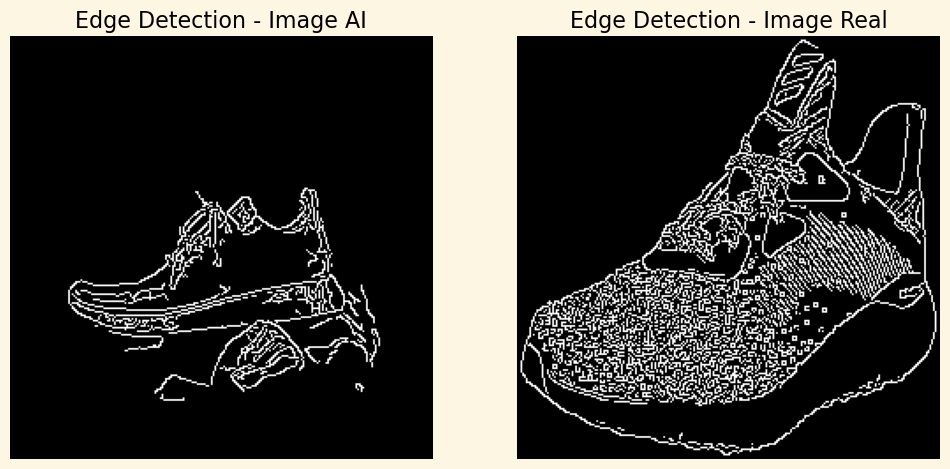

In [17]:
edges_a = cv2.Canny(image_a, 100, 200)
edges_b = cv2.Canny(image_b, 100, 200)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(edges_a, cmap='gray')
plt.title('Edge Detection - Image AI')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edges_b, cmap='gray')
plt.title('Edge Detection - Image Real')
plt.axis('off')

plt.show()


Grayscale hist: Shows the distribution of grayscale intensity values, useful for analyzing contrast and brightness.

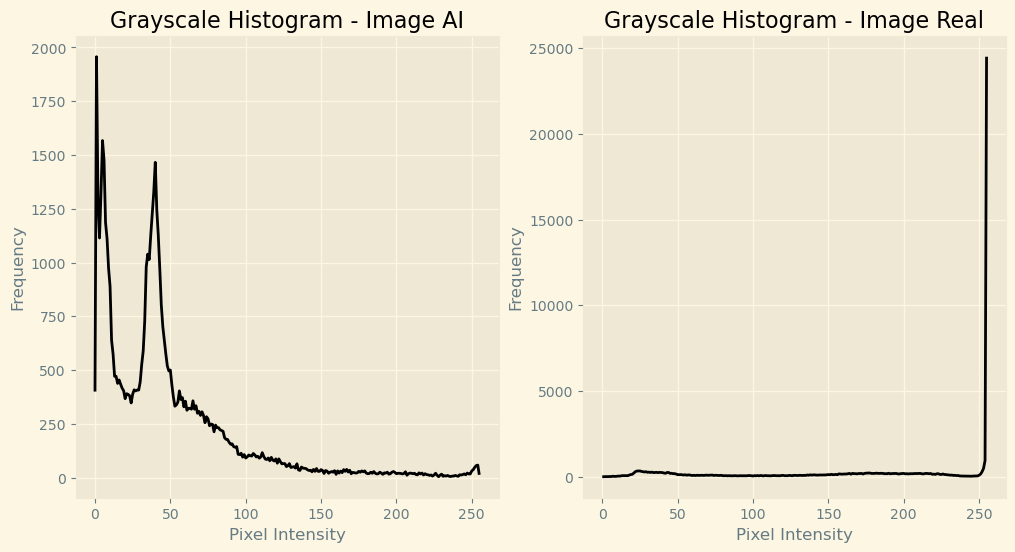

In [18]:
gray_a = cv2.cvtColor(image_a, cv2.COLOR_BGR2GRAY)
gray_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2GRAY)

# Calculate histograms
hist_a = cv2.calcHist([gray_a], [0], None, [256], [0, 256])
hist_b = cv2.calcHist([gray_b], [0], None, [256], [0, 256])

# Plot grayscale histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(hist_a, color='k')
plt.title('Grayscale Histogram - Image AI')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(hist_b, color='k')
plt.title('Grayscale Histogram - Image Real')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.show()

Mean Color Comparison: Compares the average color values across different sets of images (e.g., AI vs. real images).

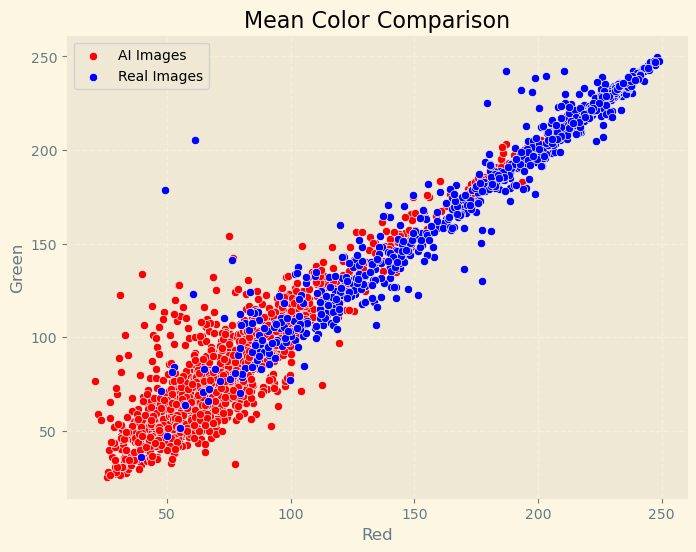

In [20]:
# Convert average color arrays to pandas DataFrames for easier manipulation
ai_avg_colors_df = pd.DataFrame(ai_avg_colors, columns=['Red', 'Green', 'Blue'])
real_avg_colors_df = pd.DataFrame(real_avg_colors, columns=['Red', 'Green', 'Blue'])

# Plotting the scatter plot with Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ai_avg_colors_df, x='Red', y='Green', color='red', label='AI Images', marker='o')
sns.scatterplot(data=real_avg_colors_df, x='Red', y='Green', color='blue', label='Real Images', marker='o')
plt.title('Mean Color Comparison')
plt.xlabel('Red')
plt.ylabel('Green')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Pixel Intensity Heatmap: Visualizes the intensity distribution across the image.

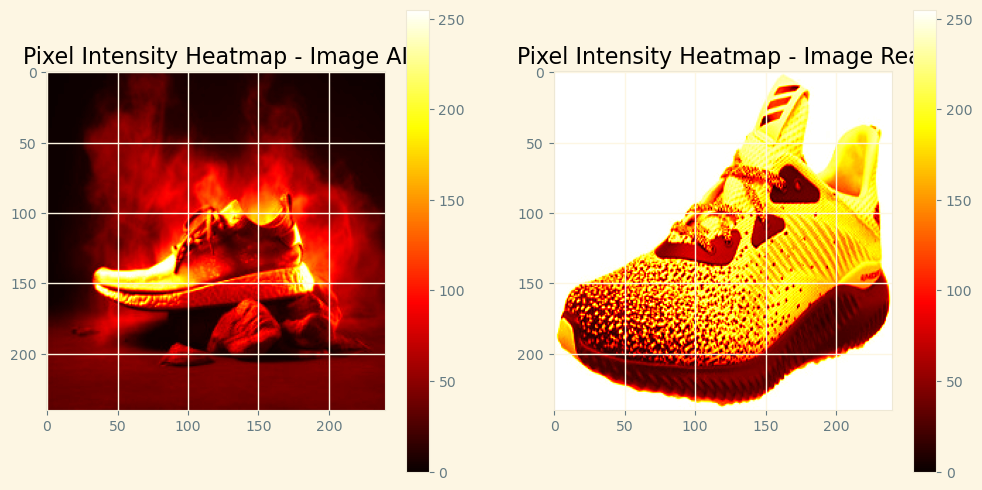

In [21]:
gray_a = cv2.cvtColor(image_a, cv2.COLOR_BGR2GRAY)
gray_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2GRAY)

# Plot pixel intensity heatmaps
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(gray_a, cmap='hot')
plt.title('Pixel Intensity Heatmap - Image AI')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(gray_b, cmap='hot')
plt.title('Pixel Intensity Heatmap - Image Real')
plt.colorbar()

plt.show()

Frequency of Dominant Colors (Clustered Colors): Uses k-means clustering to find and visualize the dominant colors in an image.

C:\Users\Dell Pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dell Pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


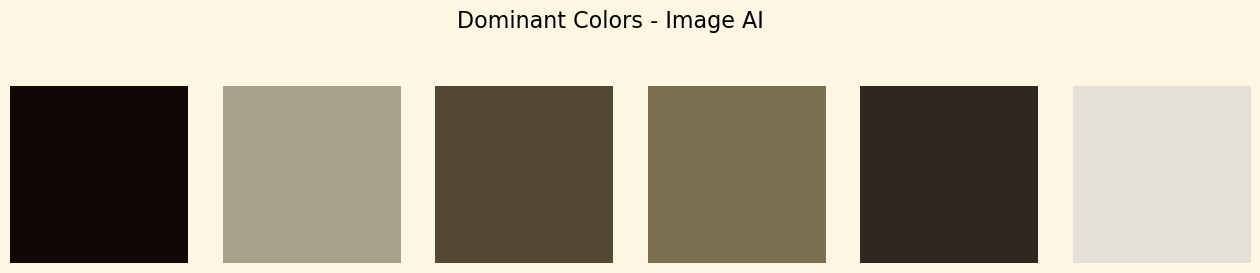

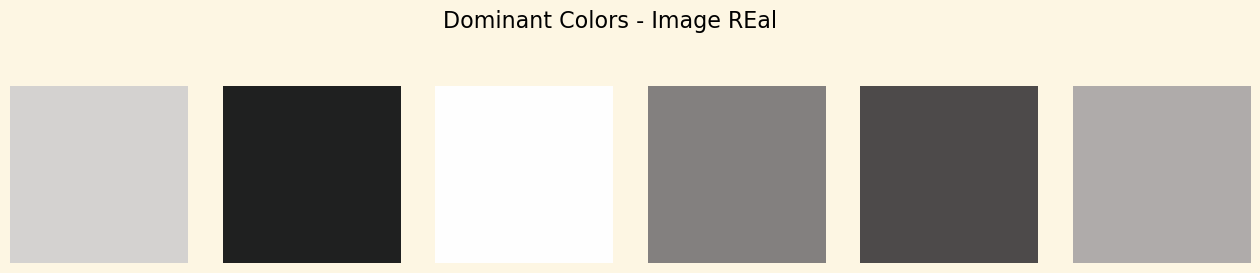

In [22]:
from sklearn.cluster import KMeans

# Convert images to numpy arrays
pixels_a = np.float32(image_a.reshape(-1, 3))
pixels_b = np.float32(image_b.reshape(-1, 3))

# Number of dominant colors
n_colors = 6

# KMeans clustering for image_a
kmeans_a = KMeans(n_clusters=n_colors).fit(pixels_a)
colors_a = kmeans_a.cluster_centers_

# KMeans clustering for image_b
kmeans_b = KMeans(n_clusters=n_colors).fit(pixels_b)
colors_b = kmeans_b.cluster_centers_

# Plot dominant colors for image_a
plt.figure(figsize=(16, 6))
for idx, color in enumerate(colors_a):
    plt.subplot(2, n_colors, idx + 1)
    plt.imshow([[color / 255]])
    plt.axis('off')
plt.suptitle('Dominant Colors - Image AI', fontsize=16)
plt.show()

# Plot dominant colors for image_b
plt.figure(figsize=(16, 6))
for idx, color in enumerate(colors_b):
    plt.subplot(2, n_colors, idx + 1)
    plt.imshow([[color / 255]])
    plt.axis('off')
plt.suptitle('Dominant Colors - Image REal', fontsize=16)
plt.show()

Spatial Frequency Analysis (Fourier Transform): Analyzes the frequency components of the image, useful for texture and pattern recognition.

Boxplot of Image Intensity Values: hows the distribution of intensity values and identifies outliers.

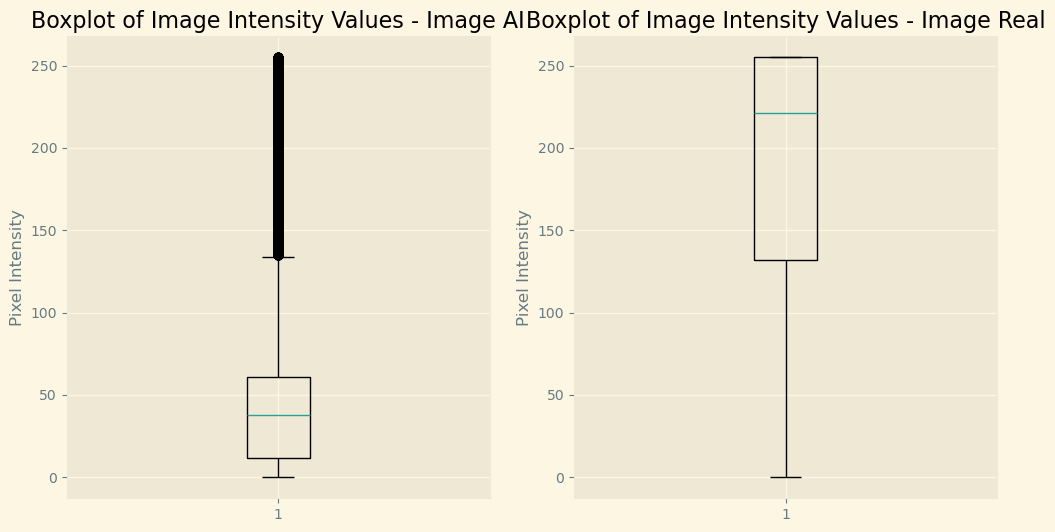

In [23]:
# Convert images to grayscale
gray_a = cv2.cvtColor(image_a, cv2.COLOR_BGR2GRAY)
gray_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2GRAY)

# Plot boxplot of image intensity values for image_a
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.boxplot(gray_a.ravel())
plt.title('Boxplot of Image Intensity Values - Image AI')
plt.ylabel('Pixel Intensity')

# Plot boxplot of image intensity values for image_b
plt.subplot(1, 2, 2)
plt.boxplot(gray_b.ravel())
plt.title('Boxplot of Image Intensity Values - Image Real')
plt.ylabel('Pixel Intensity')

plt.show()

10. Kernel Density Estimation (KDE) Plot: Visualizes the probability density function of the pixel intensity values.

C:\Users\Dell Pc\AppData\Local\Temp\ipykernel_12720\2087648634.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gray_a.ravel(), shade=True, cmap='viridis')
C:\Users\Dell Pc\AppData\Local\Temp\ipykernel_12720\2087648634.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gray_b.ravel(), shade=True, cmap='viridis')


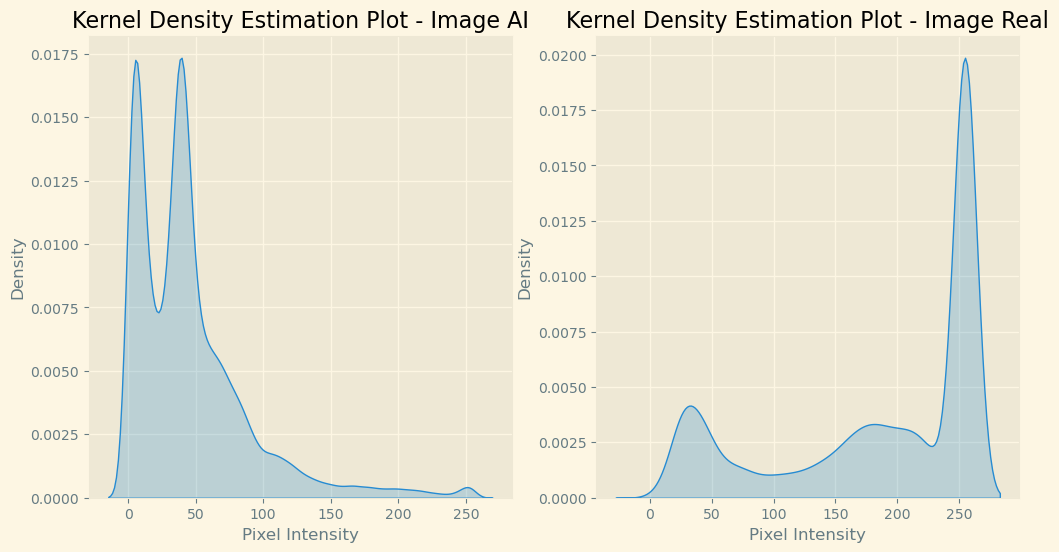

In [24]:
import seaborn as sns

# Convert images to grayscale
gray_a = cv2.cvtColor(image_a, cv2.COLOR_BGR2GRAY)
gray_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2GRAY)

# Plot kernel density estimation plot for image_a
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(gray_a.ravel(), shade=True, cmap='viridis')
plt.title('Kernel Density Estimation Plot - Image AI')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')

# Plot kernel density estimation plot for image_b
plt.subplot(1, 2, 2)
sns.kdeplot(gray_b.ravel(), shade=True, cmap='viridis')
plt.title('Kernel Density Estimation Plot - Image Real')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')

plt.show()


feature extraction: We can apply dimensionality reduction techniques like t-SNE and UMAP to visualize the images in lower dimensions.

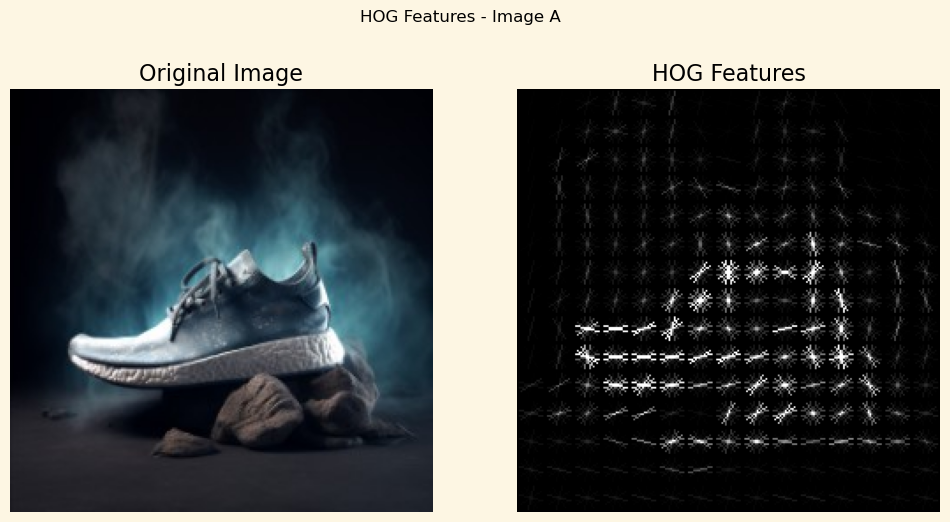

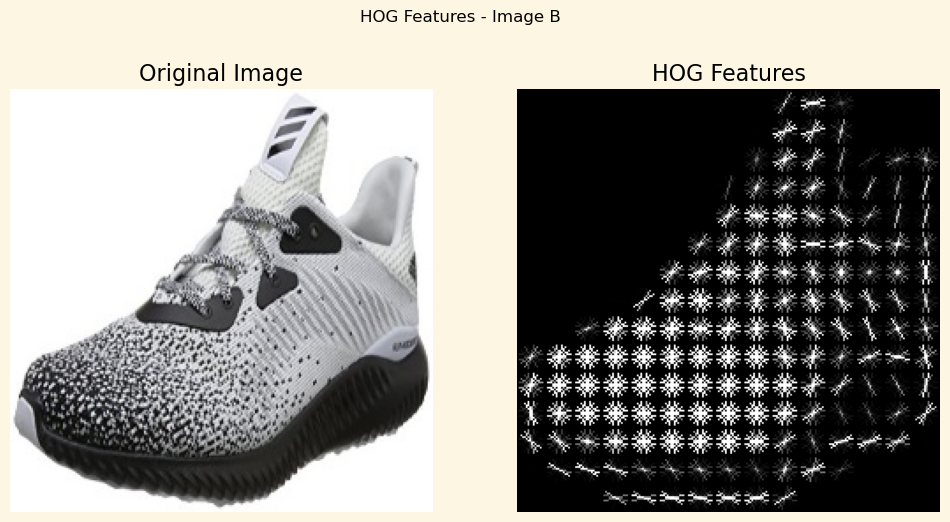

In [25]:
from skimage.feature import hog
from skimage import exposure

# Define function to extract HOG features and plot them
def extract_and_plot_hog(image, title):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Extract HOG features
    features, hog_image = hog(gray_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    
    # Plot original image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot HOG features
    plt.subplot(1, 2, 2)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    plt.title('HOG Features')
    plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Apply feature extraction and plot HOG features for image A
extract_and_plot_hog(image_a, 'HOG Features - Image A')

# Apply feature extraction and plot HOG features for image B
extract_and_plot_hog(image_b, 'HOG Features - Image B')


 Image Heatmap Overlay: Overlays a heatmap on top of the image to highlight areas of interest.

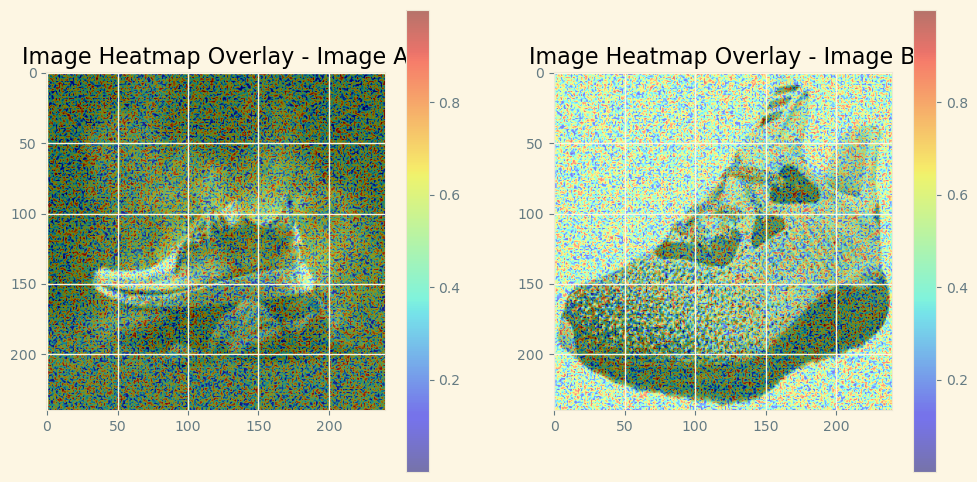

In [26]:
# Create an example heatmap (random data)
heatmap_a = np.random.rand(image_a.shape[0], image_a.shape[1])  # Example heatmap data
heatmap_b = np.random.rand(image_b.shape[0], image_b.shape[1])  # Example heatmap data

# Overlay heatmap on image for image_a
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_a)
plt.imshow(heatmap_a, alpha=0.5, cmap='jet', interpolation='bilinear')
plt.title('Image Heatmap Overlay - Image A')
plt.colorbar()

# Overlay heatmap on image for image_b
plt.subplot(1, 2, 2)
plt.imshow(image_b)
plt.imshow(heatmap_b, alpha=0.5, cmap='jet', interpolation='bilinear')
plt.title('Image Heatmap Overlay - Image B')
plt.colorbar()

plt.show()

Image Segmentation Visualization: Visualizes different segments or regions within the image.

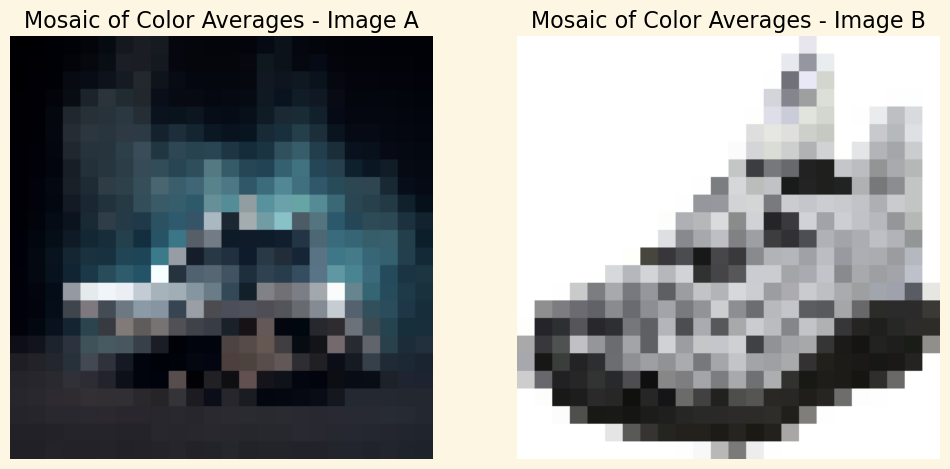

In [27]:
from scipy.ndimage import uniform_filter

def create_mosaic(image, tile_size):
    h, w, _ = image.shape
    image = cv2.resize(image, (w // tile_size, h // tile_size))
    image = cv2.resize(image, (w, h), interpolation=cv2.INTER_NEAREST)
    return image

# Create mosaic of color averages for image_a
mosaic_a = create_mosaic(image_a, tile_size=10)

# Create mosaic of color averages for image_b
mosaic_b = create_mosaic(image_b, tile_size=10)

# Plot mosaic of color averages for image_a
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(mosaic_a, cv2.COLOR_BGR2RGB))
plt.title('Mosaic of Color Averages - Image A')
plt.axis('off')

# Plot mosaic of color averages for image_b
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(mosaic_b, cv2.COLOR_BGR2RGB))
plt.title('Mosaic of Color Averages - Image B')
plt.axis('off')

plt.show()


Gaussian Mixture Model (GMM) Clustering Visualization: Applies GMM clustering to the image and visualizes the resulting clusters.

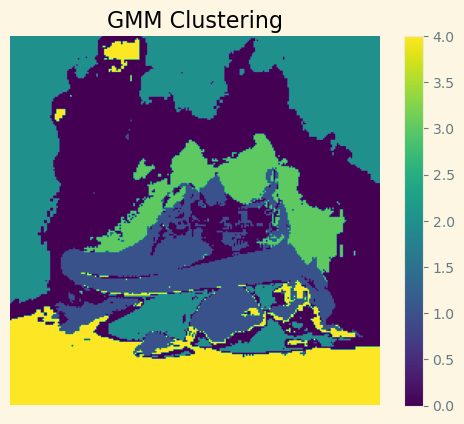

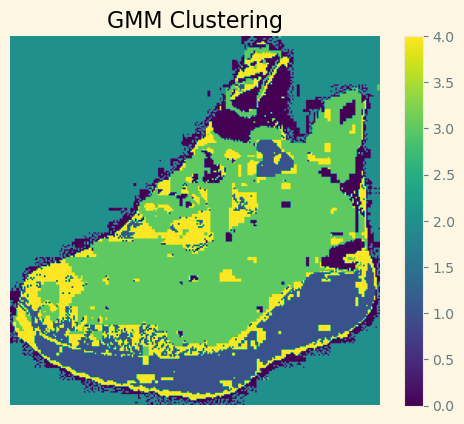

In [28]:
from sklearn.mixture import GaussianMixture

# Function to apply GMM clustering and visualize the clustered image
def apply_gmm_and_visualize(image, n_components):
    # Convert image to numpy array
    pixels = np.float32(image.reshape(-1, 3))
    
    # Initialize GMM model
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    
    # Fit GMM model
    gmm.fit(pixels)
    
    # Predict cluster labels
    labels = gmm.predict(pixels)
    
    # Reshape labels to match image shape
    clustered_image = labels.reshape(image.shape[:2])
    
    # Plot clustered image
    plt.imshow(clustered_image, cmap='viridis')
    plt.title('GMM Clustering')
    plt.colorbar()
    plt.axis('off')
    plt.show()

# Apply GMM clustering and visualize for image A
apply_gmm_and_visualize(image_a, n_components=5)

# Apply GMM clustering and visualize for image B
apply_gmm_and_visualize(image_b, n_components=5)


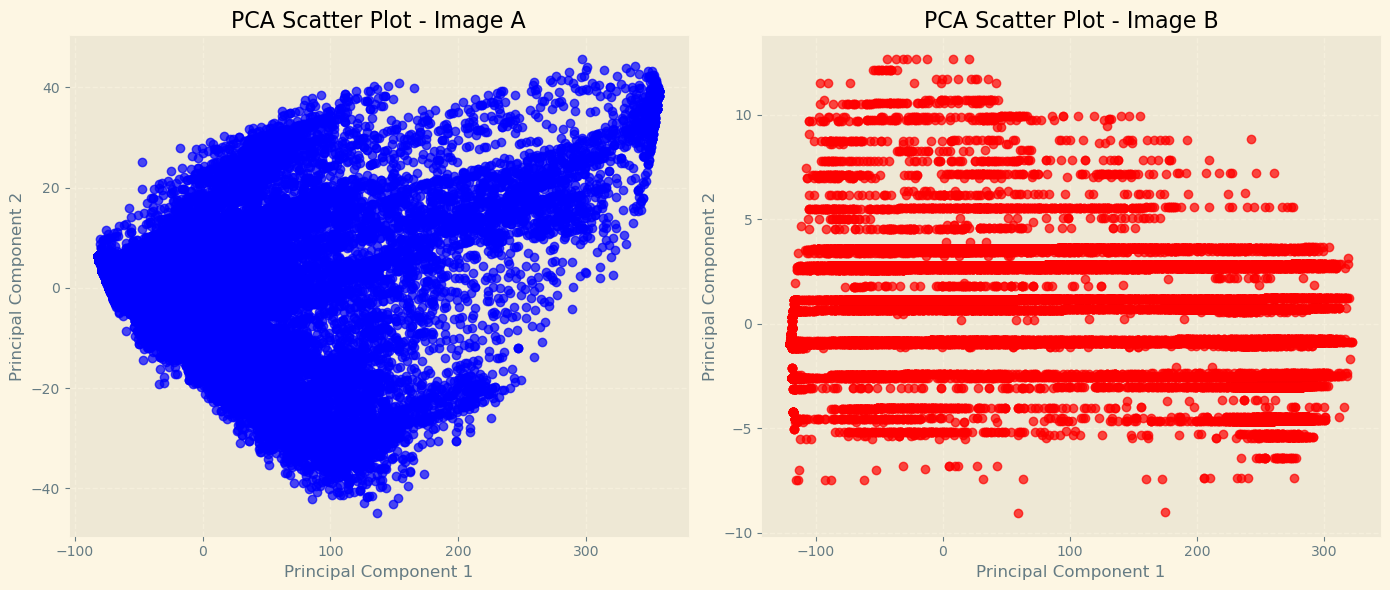

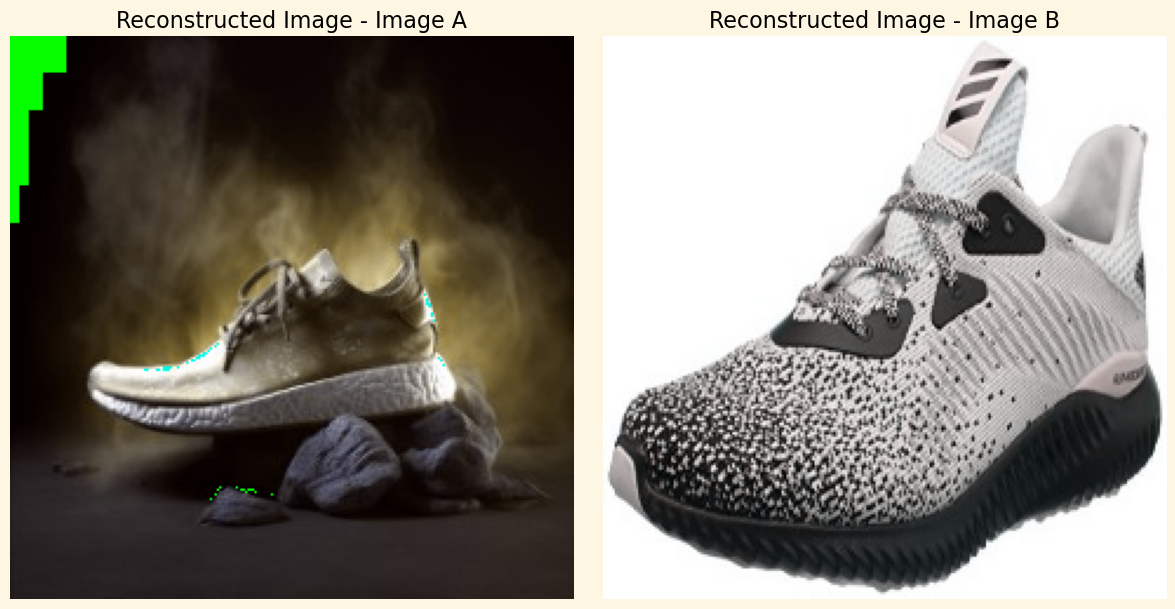

In [29]:
from sklearn.decomposition import PCA

# Function to apply PCA and reconstruct images
def apply_pca_and_reconstruct(image, n_components):
    # Convert image to numpy array
    pixels = np.float32(image.reshape(-1, 3))
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(pixels)
    
    # Reconstruct image
    reconstructed_pixels = pca.inverse_transform(pca_result)
    reconstructed_image = np.uint8(reconstructed_pixels.reshape(image.shape))
    
    return pca_result, reconstructed_image

# Apply PCA and reconstruct images for images A and B
n_components = 2  # Number of components to keep

pca_result_a, reconstructed_image_a = apply_pca_and_reconstruct(image_a, n_components)
pca_result_b, reconstructed_image_b = apply_pca_and_reconstruct(image_b, n_components)

# Plot PCA scatter plots for images A and B
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(pca_result_a[:, 0], pca_result_a[:, 1], color='b', marker='o', alpha=0.7)
plt.title('PCA Scatter Plot - Image A')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(1, 2, 2)
plt.scatter(pca_result_b[:, 0], pca_result_b[:, 1], color='r', marker='o', alpha=0.7)
plt.title('PCA Scatter Plot - Image B')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Plot reconstructed images for images A and B
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(reconstructed_image_a)
plt.title('Reconstructed Image - Image A')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_b)
plt.title('Reconstructed Image - Image B')
plt.axis('off')

plt.tight_layout()
plt.show()


for AI image: 


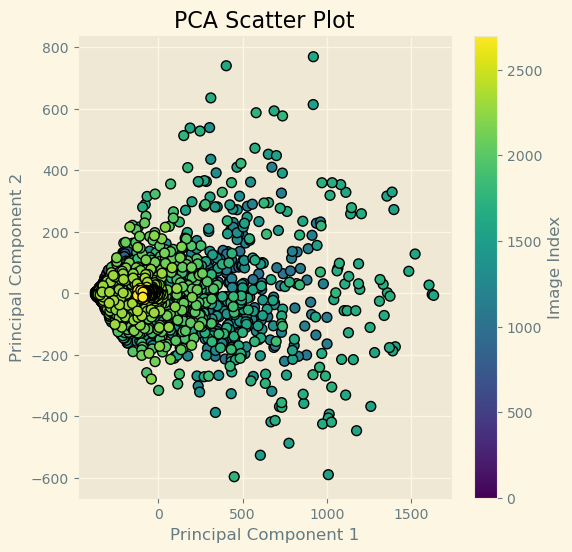

for Real image: 


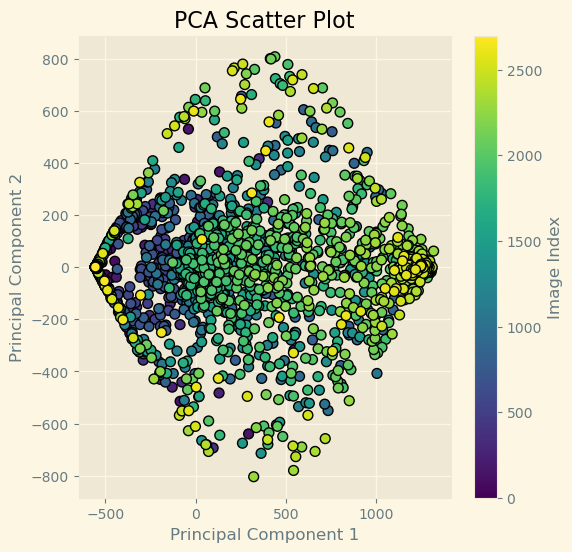

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to apply PCA and reconstruct images
def apply_pca_and_reconstruct(image, n_components):
    # Convert image to numpy array
    pixels = np.float32(image.reshape(-1, 8, 8))  # Reshape to the original image size
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(pixels.reshape(pixels.shape[0], -1))  # Flatten each image
    
    # Plot PCA scatter plot
    plt.figure(figsize=(6, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=np.arange(len(pca_result)), cmap='viridis', edgecolor='k', s=50)
    plt.title('PCA Scatter Plot')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Image Index')
    plt.grid(True)
    plt.show()

# Apply PCA and plot PCA scatter plot for images A and B
n_components = 2  # Number of components to keep

print("for AI image: ")
apply_pca_and_reconstruct(image_a, n_components)
print("for Real image: ")
apply_pca_and_reconstruct(image_b, n_components)


Principal compnents of AI-image


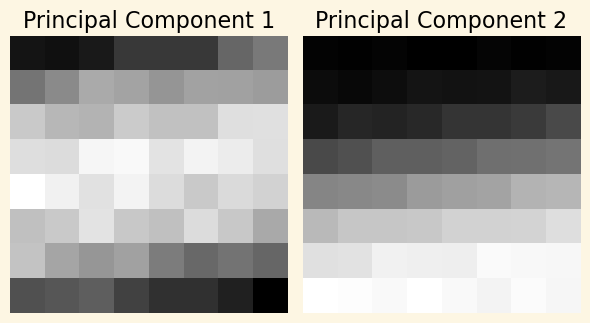

Principal compnents of Real Image


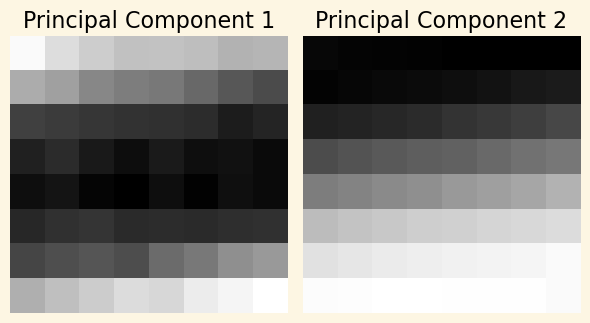

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to apply PCA and plot principal components
def apply_pca_and_plot(image, n_components):
    # Convert image to numpy array
    pixels = np.float32(image.reshape(-1, 8, 8))  # Reshape to the original image size
    
    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(pixels.reshape(pixels.shape[0], -1))  # Flatten each image
    
    # Plot principal components
    plt.figure(figsize=(6, 6))
    for i in range(n_components):
        plt.subplot(1, n_components, i + 1)
        plt.imshow(pca.components_[i].reshape(8, 8), cmap='gray')
        plt.title(f'Principal Component {i + 1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Apply PCA and plot principal components for images A and B
n_components = 2  # Number of components to keep

print("Principal compnents of AI-image")
apply_pca_and_plot(image_a, n_components)
print("Principal compnents of Real Image")
apply_pca_and_plot(image_b, n_components)


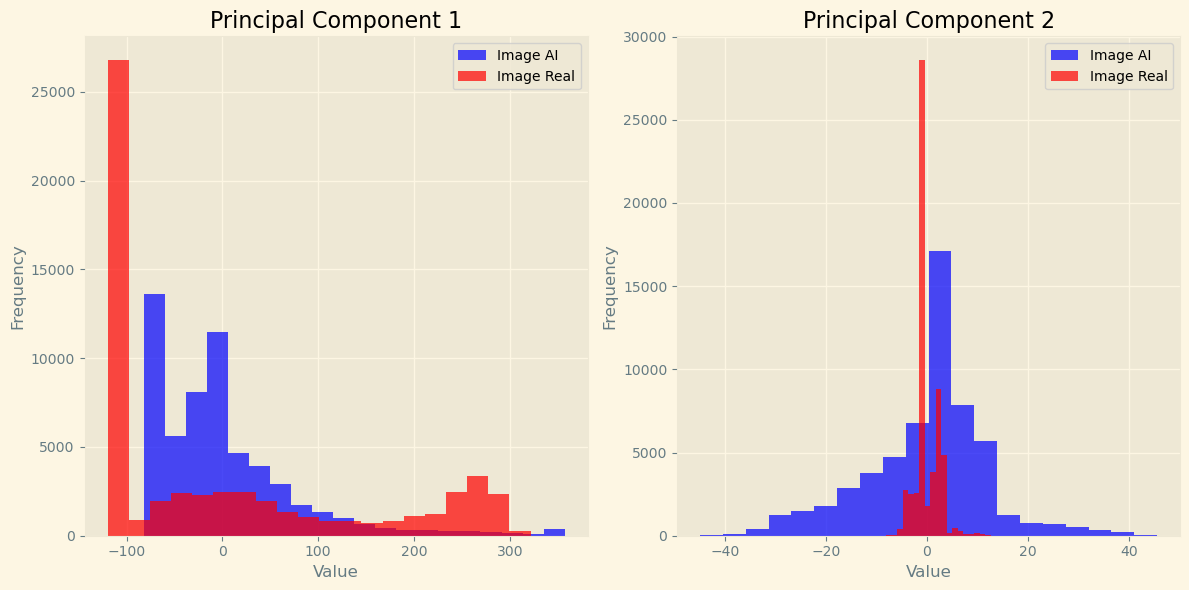

In [32]:
# Individual Component Analysis
plt.figure(figsize=(12, 6))
for i in range(n_components):
    plt.subplot(1, n_components, i + 1)
    plt.hist(pca_result_a[:, i], bins=20, color='b', alpha=0.7, label='Image AI')
    plt.hist(pca_result_b[:, i], bins=20, color='r', alpha=0.7, label='Image Real')
    plt.title(f'Principal Component {i + 1}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

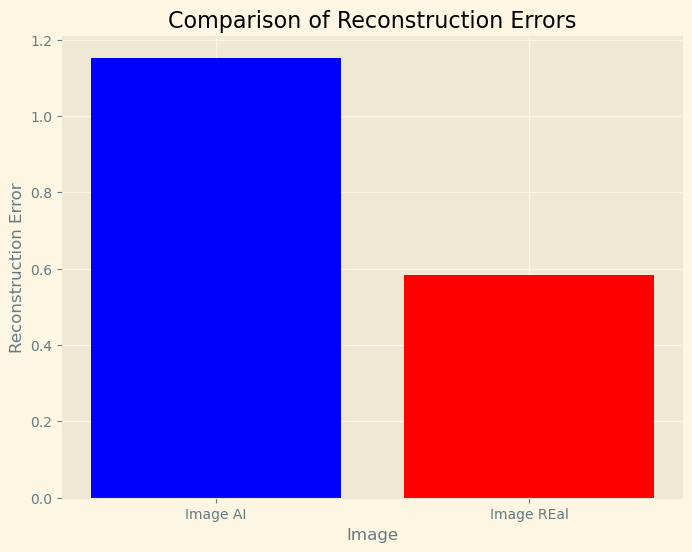

In [33]:
# 3D Scatter Plot of Principal Components
from mpl_toolkits.mplot3d import Axes3D

# Comparison of Reconstruction Errors
reconstruction_error_a = np.mean((image_a - reconstructed_image_a) ** 2)
reconstruction_error_b = np.mean((image_b - reconstructed_image_b) ** 2)

plt.figure(figsize=(8, 6))
plt.bar(['Image AI', 'Image REal'], [reconstruction_error_a, reconstruction_error_b], color=['b', 'r'])
plt.title('Comparison of Reconstruction Errors')
plt.xlabel('Image')
plt.ylabel('Reconstruction Error')
plt.show()


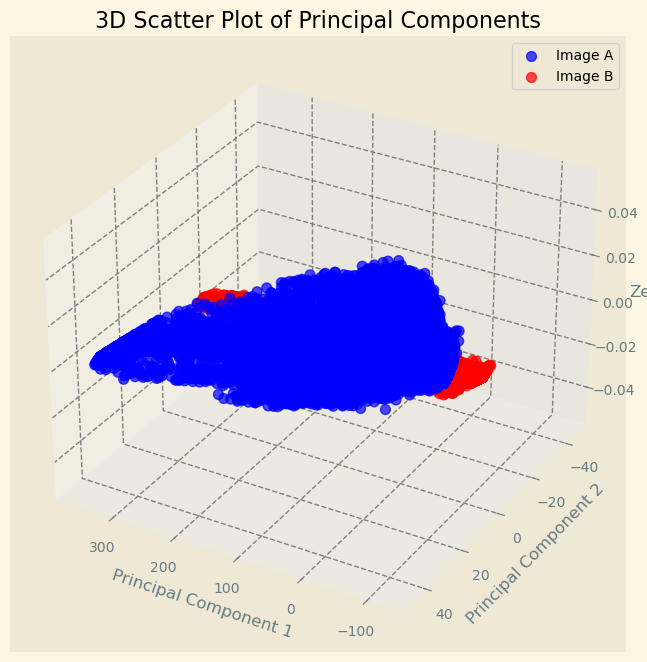

In [34]:
# 3D Scatter Plot of Principal Components
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result_a[:, 0], pca_result_a[:, 1], np.zeros_like(pca_result_a[:, 0]), color='b', label='Image A', alpha=0.7, s=50)
ax.scatter(pca_result_b[:, 0], pca_result_b[:, 1], np.zeros_like(pca_result_b[:, 0]), color='r', label='Image B', alpha=0.7, s=50)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Zero')
ax.set_title('3D Scatter Plot of Principal Components')

# Apply the color scheme and style
ax.xaxis._axinfo['grid'].update(color='gray', linestyle='--')
ax.yaxis._axinfo['grid'].update(color='gray', linestyle='--')
ax.zaxis._axinfo['grid'].update(color='gray', linestyle='--')

ax.legend()
ax.view_init(elev=30, azim=120)  # Adjust viewing angle
plt.show()


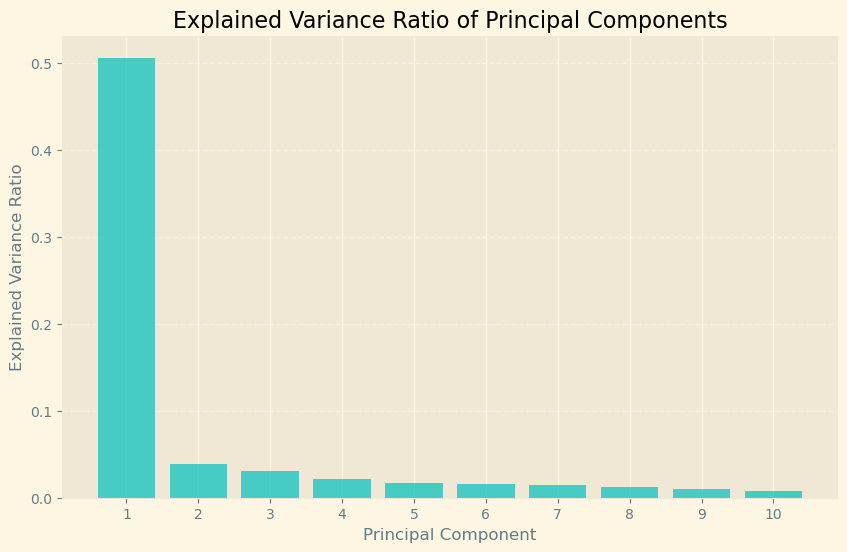

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Combine the real and AI-generated images into a single array
all_images = np.concatenate((real_images, ai_images), axis=0)

# Standardize the pixel values
scaler = StandardScaler()
scaled_images = scaler.fit_transform(all_images.reshape(len(all_images), -1))

# Apply PCA
pca = PCA(n_components=10)  # Let's take the top 10 components for illustration
pca_result = pca.fit_transform(scaled_images)

# Plot the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, color='c', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
